In [1]:
dataset_name = "infection"

In [2]:
# Import the utility functions
import torch
from src.experiment_utils import FaithfulnessExperiment, FaithfulnessExperimentAnalysis

device = torch.device("cpu")
dataset_folder = "/workspace/Datasets"
model_folder = "/workspace/Models"
config = "2L1H"

# Load the network data locally (for reproduction)
data = torch.load(f"{dataset_folder}/Infection_50002d_sp.pt").to(device)
# Load model as a whole
model = torch.load(f"{model_folder}/GAT_{dataset_name}_{config}_sp.pt").to(device)
model.eval()

with torch.no_grad():
    _  = model(data.x, data.edge_index, return_att = True)
    att = list(model.att)

In [22]:
att_0 = torch.zeros((data.num_nodes, data.num_nodes))
att_0[att[0][0][1], att[0][0][0]] = att[0][1].squeeze()

att_1 = torch.zeros((data.num_nodes, data.num_nodes))
att_1[att[1][0][1], att[1][0][0]] = att[1][1].squeeze()

In [24]:
target_node = 3

In [25]:
select_matrix = torch.zeros_like(att_0)
select_matrix[target_node, :] = 1

In [29]:
result_2L1H = (att_1)[target_node, :].expand_as(att_1).t() * att_0 +\
    select_matrix * att_1

In [2]:
import torch
from src.experiment_utils import FaithfulnessExperiment, FaithfulnessExperimentAnalysis

device = torch.device("cpu")
dataset_folder = "/workspace/Datasets"
model_folder = "/workspace/Models"
config = "3L1H"

# Load the network data locally (for reproduction)
data = torch.load(f"{dataset_folder}/Infection_50003d_sp.pt").to(device)
# Load model as a whole
model = torch.load(f"{model_folder}/GAT_{dataset_name}_{config}_sp.pt").to(device)
model.eval()

with torch.no_grad():
    _  = model(data.x, data.edge_index, return_att = True)
    att = list(model.att)

In [3]:
att_0 = torch.zeros((data.num_nodes, data.num_nodes))
att_0[att[0][0][1], att[0][0][0]] = att[0][1].squeeze()

att_1 = torch.zeros((data.num_nodes, data.num_nodes))
att_1[att[1][0][1], att[1][0][0]] = att[1][1].squeeze()

att_2 = torch.zeros((data.num_nodes, data.num_nodes))
att_2[att[2][0][1], att[2][0][0]] = att[2][1].squeeze()

In [4]:
target_node = data.unique_solution_nodes[0]
print(f"Target: {target_node}")

Target: 8


In [5]:
select_matrix = torch.zeros_like(att_0)
select_matrix[target_node, :] = 1

In [6]:
result_3L1H = (att_2 @ att_1)[target_node, :].expand_as(att_0).t() * att_0 +\
    (att_2)[target_node, :].expand_as(att_0).t() * att_1 +\
    select_matrix * att_2

Now we need a sanity check.

In [108]:
experiment_artifact_folder = "/workspace/Experimental_Artifacts"

# load the results
prev_result = torch.load(f"{experiment_artifact_folder}/Faithfulness_GAT_{dataset_name}_{config}_Attributions.pt")

# Get edge lists
faithfulness_experiment = FaithfulnessExperiment(
    model = model,
    data = data,
    device = device,
    )

faithfulness_experiment.set_target_nodes(
    data.unique_solution_nodes
)

att_matrix_dict, correction_matrix_dict = faithfulness_experiment._prep_to_get_attattribute()
att_matrix_dict_sim, correction_matrix_dict_sim = faithfulness_experiment._prep_to_get_attattribute_sim()

Target nodes set...
Generating edge lists within 3 hops of target nodes...
...Done


In [140]:
@torch.no_grad()
def generate_att_dict(model, data, sparse: bool = True):
    """
    Generates a dictionary of attention matrices from a model.
    """
    _ = model(data.x, data.edge_index, return_att=True)
    num_nodes = data.num_nodes
    att = model.att
    att_matrix_dict = {}
    for idx, att_info in enumerate(att):
        if sparse:
            att_matrix_dict[idx] = torch.sparse_coo_tensor(att_info[0], 
                                                        att_info[1].mean(dim=1).squeeze(), 
                                                        size=(num_nodes, num_nodes)).t()
        else:
            att_matrix_dict[idx] = torch.zeros((num_nodes, num_nodes))
            # Already transposed
            att_matrix_dict[idx][att_info[0][1], att_info[0][0]] = att_info[1].mean(dim=1).squeeze()
    return att_matrix_dict

@torch.no_grad()
def generate_att_dict_sim(model, data, sparse: bool = True):    
    """
    Generates a dictionary of attention matrices from a model.
    """
    _ = model(data.x, data.edge_index, return_att=True)
    num_nodes = data.num_nodes
    att = model.att
    att_matrix_dict_sim = {}
    for idx, att_info in enumerate(att):
        if sparse:
            att_matrix_dict_sim[idx] = torch.sparse_coo_tensor(att_info[0], 
                                                        torch.ones_like(att_info[1].mean(dim=1).squeeze()), 
                                                        size=(num_nodes, num_nodes)).t()
        else:
            att_matrix_dict_sim[idx] = torch.zeros((num_nodes, num_nodes))
            # Already transposed
            att_matrix_dict_sim[idx][att_info[0][1], att_info[0][0]] = torch.ones_like(att_info[1].mean(dim=1).squeeze())
    return att_matrix_dict_sim

def _prep_to_get_attattribute(sparse: bool = False, num_hops: int = 3):
    att_matrix_dict = generate_att_dict(model=model, data=data, sparse=False)
    if num_hops == 3:
        correction_matrix_dict = {}
        if sparse:
            correction_matrix_dict[0] = torch.sparse.mm(att_matrix_dict[2], att_matrix_dict[1])
        else:
            correction_matrix_dict[0] = torch.mm(att_matrix_dict[2], att_matrix_dict[1])
    else:
        correction_matrix_dict = None
        
    return att_matrix_dict, correction_matrix_dict

def _prep_to_get_attattribute_sim(sparse: bool = False, num_hops: int = 3):
    att_matrix_dict_sim = generate_att_dict_sim(model=model, data=data, sparse=False)
    if num_hops == 3:
        correction_matrix_dict_sim = {}
        if sparse:
            correction_matrix_dict_sim[0] = torch.sparse.mm(att_matrix_dict_sim[2], att_matrix_dict_sim[1])
        else:
            correction_matrix_dict_sim[0] = torch.mm(att_matrix_dict_sim[2], att_matrix_dict_sim[1])
    else:
        correction_matrix_dict_sim = None
        
    return att_matrix_dict_sim, correction_matrix_dict_sim

In [141]:
att_matrix_dict, correction_matrix_dict = _prep_to_get_attattribute()
att_matrix_dict_sim, correction_matrix_dict_sim = _prep_to_get_attattribute_sim()

In [142]:
def attattribute_batch(ref_node,
                att_matrix_dict, 
                correction_matrix_dict = None) -> torch.Tensor:
    # Get the number of hops
    num_of_hops = len(att_matrix_dict)
    
    select_matrix = torch.zeros_like(att_matrix_dict[0])
    select_matrix[ref_node, :] = 1
    
    if num_of_hops == 1:
        result_matrix = select_matrix * att_matrix_dict[0]
    elif num_of_hops == 2:
        result_matrix = att_matrix_dict[1][ref_node, :].expand_as(att_matrix_dict[0]).t() * att_matrix_dict[0] +\
                        select_matrix * att_matrix_dict[1]
    elif num_of_hops == 3:
        result_matrix = correction_matrix_dict[0][ref_node, :].expand_as(att_matrix_dict[0]).t() * att_matrix_dict[0] +\
                        att_matrix_dict[2][ref_node, :].expand_as(att_matrix_dict[0]).t() * att_matrix_dict[1] +\
                        select_matrix * att_matrix_dict[2]
    else:
        raise NotImplementedError("This function only supports up to 3-hop attention.")
    
    return result_matrix

def attattribute_sim_batch(ref_node: int,
                att_matrix_dict, 
                att_matrix_dict_sim, 
                correction_matrix_dict = None) -> torch.Tensor:
    # Get the number of hops
    num_of_hops = len(att_matrix_dict)
    
    select_matrix = torch.zeros_like(att_matrix_dict[0])
    select_matrix[ref_node, :] = 1
    
    if num_of_hops == 1:
        result_matrix = select_matrix * att_matrix_dict[0]
    elif num_of_hops == 2:
        result_matrix = att_matrix_dict_sim[1][ref_node, :].expand_as(att_matrix_dict[0]).t() * att_matrix_dict[0] +\
                        select_matrix * att_matrix_dict[1]
    elif num_of_hops == 3:
        result_matrix = correction_matrix_dict[0][ref_node, :].expand_as(att_matrix_dict[0]).t() * att_matrix_dict[0] +\
                        att_matrix_dict_sim[2][ref_node, :].expand_as(att_matrix_dict[0]).t() * att_matrix_dict[1] +\
                        select_matrix * att_matrix_dict[2]
    else:
        raise NotImplementedError("This function only supports up to 3-hop attention.")
    
    return result_matrix

In [143]:
attattribute_batch(ref_node=1,
                att_matrix_dict=att_matrix_dict,
                correction_matrix_dict=correction_matrix_dict)

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4815, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [144]:
attattribute_sim_batch(ref_node=1,
                att_matrix_dict=att_matrix_dict,
                att_matrix_dict_sim=att_matrix_dict_sim,
                correction_matrix_dict=correction_matrix_dict_sim)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [8]:
edge_lists = faithfulness_experiment.edge_lists_dict

In [9]:
idx = 50

In [10]:
from src.attention_analysis_utils import attattribute

attattribute(target_edge=edge_lists[target_node][idx],
            ref_node=target_node,   
            att_matrix_dict=att_matrix_dict,
            correction_matrix_dict=correction_matrix_dict)

0.1869354099035263

In [11]:
result_3L1H[edge_lists[target_node][idx][1], edge_lists[target_node][idx][0]].item()

0.1869354099035263

In [12]:
result_list1 = []
result_list2 = []

for edge in edge_lists[target_node]:
    result_list1.append(attattribute(target_edge=edge,
            ref_node=target_node,   
            att_matrix_dict=att_matrix_dict,
            correction_matrix_dict=correction_matrix_dict))
    result_list2.append(result_3L1H[edge[1], edge[0]].item())

In [13]:
result_list1 == result_list2

True

Runtime analysis

In [14]:
def element_wise_calculation(edge_lists, target_node_list, att_matrix_dict, correction_matrix_dict):
    result_list = []
    for target_node in target_node_list:
        for edge in edge_lists[target_node]:
            result_list.append(attattribute(target_edge=edge,
                    ref_node=target_node,   
                    att_matrix_dict=att_matrix_dict,
                    correction_matrix_dict=correction_matrix_dict))
    return result_list

def matrix_calculation(edge_lists, target_node_list):
    result_list = []
    for target_node in target_node_list:
        for edge in edge_lists[target_node]:
            result_list.append(result_3L1H[edge[1], edge[0]].item())
    return result_list

Time: Calculation of full experiment

In [15]:
%%timeit -n 100 -r 5
element_wise_calculation(edge_lists, data.unique_solution_nodes, att_matrix_dict, correction_matrix_dict)

11.6 s ± 35.9 ms per loop (mean ± std. dev. of 5 runs, 100 loops each)


In [16]:
%%timeit -n 100 -r 5
matrix_calculation(edge_lists, data.unique_solution_nodes)

116 ms ± 535 µs per loop (mean ± std. dev. of 5 runs, 100 loops each)


Time: Calculation of single node

In [17]:
%%timeit -n 100 -r 5
element_wise_calculation(edge_lists, [data.unique_solution_nodes[0]], att_matrix_dict, correction_matrix_dict)

14 ms ± 56.6 µs per loop (mean ± std. dev. of 5 runs, 100 loops each)


In [18]:
%%timeit -n 100 -r 5
matrix_calculation(edge_lists, [data.unique_solution_nodes[0]])

183 µs ± 9.12 µs per loop (mean ± std. dev. of 5 runs, 100 loops each)


In [43]:
from src.attention_analysis_utils import (
    get_attention_raw_dict,
    process_attention_dict,
    get_computation_graph,
    get_nodes_per_level_from_comp_graph_full,
    reindex_nodes_per_level,
    translate_comp_graph,
    get_att_dict_per_layer,
    get_ATTATTTRIBUTE_edge,
    return_edges_in_k_hop,
)

from torch_geometric.utils import get_num_hops, get_num_hops, degree

def get_edge_scores(
    target_edge, comp_graph, comp_graph_new, layer_att_dict
):
    assert type(target_edge) == tuple, "target_edge must be a tuple"
    # Get ATTATTRIBUTE & ATTATTRIBUTE_sim scores
    attattribute, _ = get_ATTATTTRIBUTE_edge(
        comp_graph=comp_graph,
        comp_graph_new=comp_graph_new,
        layer_att_dict=layer_att_dict,
        target_edge=target_edge,
        verbose=False,
    )
    return attattribute

# Let's refactor tha code below as a function
def experiment_on_target_node(
    target_idx: int, data, model, self_loops=True
):
    # 1. Get the number of hops according to the model
    num_layers = get_num_hops(model)
    # 2. Get all edges within the target node's k-hop neighborhood
    edge_lists = return_edges_in_k_hop(
        data=data, target_idx=target_idx, hop=num_layers, self_loops=self_loops
    )

    # 3. For all edges in the k-hop neighborhood, we get the attribution scores
    att_dict_raw = get_attention_raw_dict(model, data)
    att_dict = process_attention_dict(att_dict_raw)
    comp_graph = get_computation_graph(
        edge_index=data.edge_index, k=num_layers, target_idx=target_idx
    )
    (
        nodes_per_level_original,
        num_nodes_per_level,
        true_node_label,
    ) = get_nodes_per_level_from_comp_graph_full(comp_graph=comp_graph)
    nodes_per_level_new = reindex_nodes_per_level(
        nodes_per_level_original, num_nodes_per_level
    )
    comp_graph_new = translate_comp_graph(
        comp_graph=comp_graph,
        nodes_per_level_new=nodes_per_level_new,
        nodes_per_level_original=nodes_per_level_original,
        degree=degree(data.edge_index[1]),
    )
    layer_att_dict = get_att_dict_per_layer(
        comp_graph=comp_graph, comp_graph_new=comp_graph_new, att_dict=att_dict
    )

    # 4. Now, get the 1) label 2) prediction 3) prediction probability 4) entropy values of the original model
    # Output without any masking
    with torch.no_grad():
        output = model(
            x=data.x, edge_index=data.edge_index, return_att=True, mask_edge=None
        )
        att = model.att
        pred = output.argmax(dim=1)[target_idx].item()  # Single integer
        pred_prob = output[target_idx].softmax(dim=0)[pred].item()  # Single float
        prob_vector = output[target_idx].softmax(dim=0)  # 1D vector of floats
        entropy = -(prob_vector * prob_vector.log()).sum().item()  # Single float
    # Get results for all edges in the k-hop neighborhood
    attattribute_list = []
    for current_edge in edge_lists:
        attattribute = get_edge_scores(
            target_edge=tuple(current_edge),
            comp_graph=comp_graph,
            comp_graph_new=comp_graph_new,
            layer_att_dict=layer_att_dict,
        )
        attattribute_list.append(attattribute)

    return attattribute_list

In [44]:
def rooted_subtree_calculation(target_node_list, data, model):
    for target_node in target_node_list:
        result_list = experiment_on_target_node(target_node, data, model)
    return result_list

For additional reference, get the runtime of previous implementation (rooted subtree)

In [46]:
%%timeit -n 10 -r 5
rooted_subtree_calculation(data.unique_solution_nodes, data, model)

4min 46s ± 544 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


In [47]:
%%timeit -n 10 -r 5
rooted_subtree_calculation([data.unique_solution_nodes[0]], data, model)

302 ms ± 757 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)


#### Visualize runtime experimental results

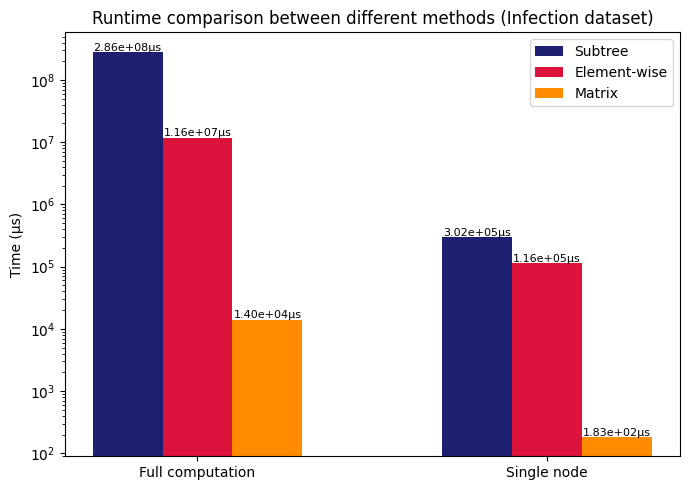

In [89]:
import numpy as np
import matplotlib.pyplot as plt

# Experimental results, [mean, std] (all in microseconds)
full_subtree_result = [286e6, 544e3]
node_subtree_result = [302e3, 757]

full_element_wise_result = [11.6e6, 35.9e3] # 11.6 s ± 35.9 ms per loop
node_element_wise_result = [116e3, 535] # 116 ms ± 535 µs per loop

full_matrix_result = [14e3, 56.6] # 14 ms ± 56.6 µs per loop
node_matrix_result = [183, 9.12] # 183 µs ± 9.12 µs per loop

# Plot the results as a bar chart
# Plot mean (first number) and std (second number) in each list
# Use colors #1e1f71 and #dc143c and #ff8c00
# First comparison: Compare full subtree vs full element-wise vs full matrix
# Second comparison: Compare node subtree vs node element-wise vs node matrix
# Set y-axis in log scale
plt.figure(figsize=(7, 5), dpi=100)
width = 0.2
ind = np.arange(2)
plt.bar(ind - width, [full_subtree_result[0], node_subtree_result[0]], width, color = "#1e1f71")
plt.bar(ind, [full_element_wise_result[0], node_element_wise_result[0]], width, color = "#dc143c")
plt.bar(ind + width, [full_matrix_result[0], node_matrix_result[0]], width, color = "#ff8c00")

# Display runtime per node as text on top of the bars
plt.text(x = ind[0] - width, y = full_subtree_result[0] + 1e7, s = f"{full_subtree_result[0]:.2e}μs", ha = "center", size = 8)
plt.text(x = ind[0], y = full_element_wise_result[0] + 1e6, s = f"{full_element_wise_result[0]:.2e}μs", ha = "center", size = 8)
plt.text(x = ind[0] + width, y = full_matrix_result[0] + 1e3, s = f"{full_matrix_result[0]:.2e}μs", ha = "center", size = 8)
plt.text(x = ind[1] - width, y = node_subtree_result[0] + 1e4, s = f"{node_subtree_result[0]:.2e}μs", ha = "center", size = 8)
plt.text(x = ind[1], y = node_element_wise_result[0] + 5e3, s = f"{node_element_wise_result[0]:.2e}μs", ha = "center", size = 8)
plt.text(x = ind[1] + width, y = node_matrix_result[0] + 1e1, s = f"{node_matrix_result[0]:.2e}μs", ha = "center", size = 8)

plt.xticks([0, 1], ["Full computation", "Single node"])
# Set legend properly
plt.legend(["Subtree", "Element-wise", "Matrix"])
plt.ylabel("Time (μs)")
plt.yscale("log")
plt.title("Runtime comparison between different methods (Infection dataset)")
plt.tight_layout()
plt.show()